In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
print("Backend actually used:", matplotlib.get_backend())
from matplotlib.patches import FancyArrowPatch
from collections import Counter
import math

import copy, matplotlib.path as mpath
mpath.Path.__deepcopy__ = lambda self, memo: self

Backend actually used: module://matplotlib_inline.backend_inline


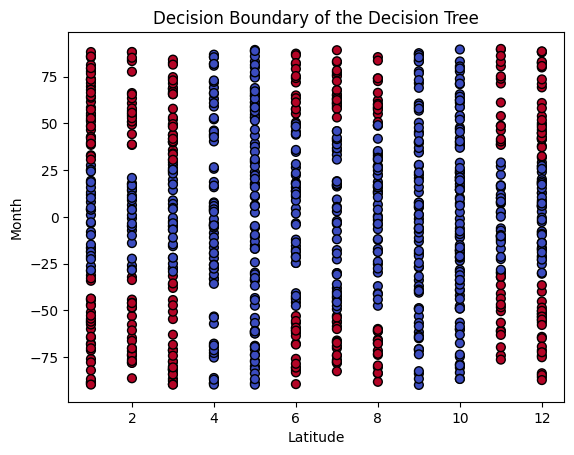

In [7]:
data = np.load('skiing_data.npz')
X = data['X']
y = data['y']


# Plot scatter
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="coolwarm", edgecolor="k")
plt.xlabel("Latitude")
plt.ylabel("Month")
plt.title("Decision Boundary of the Decision Tree")
plt.show()


In [8]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion="gini"):
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(set(y))

        # regularization - stop if max_depth is reached or if there is only one label
        if (depth >= self.max_depth or num_labels == 1):
            return {"label": Counter(y).most_common(1)[0][0]}
        
        best_split = self.best_split(X, y, num_features)

        if best_split["gain"] == 0:
            return {"label": Counter(y).most_common(1)[0][0]}

        left = self.grow_tree(best_split["X_left"], best_split["y_left"], depth + 1)
        right = self.grow_tree(best_split["X_right"], best_split["y_right"], depth + 1)

        return {
            "feature": best_split["feature"],
            "threshold": best_split["threshold"],
            "left": left,
            "right": right,
        }

    # Find the best split for the current node in the tree with respect to one feature
    # input: X, y, num_features
    # output: split -> dictionary containing the feature, threshold, gain, X_left, y_left, X_right, y_right
    def best_split(self, X, y, num_features):

        best_gain = -1
        feature, threshold, gain, X_left, X_right, y_left, y_right = None, None, None , None, None, None, None
        split = {
            "feature": feature,
            "threshold": threshold,
            "gain": gain,
            "X_left": X_left,
            "y_left": y_left,
            "X_right": X_right,
            "y_right": y_right,
        }
        
        ########## Your code goes here ##########
        for feature in range(num_features):
            X_col = X[:, feature]
            thresholds = np.unique(X_col)
            for threshold in thresholds:
                gain, X_left, y_left, X_right, y_right = self.split(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split = {
                        "feature": feature,
                        "threshold": threshold,
                        "gain": gain,
                        "X_left": X_left,
                        "y_left": y_left,
                        "X_right": X_right,
                        "y_right": y_right,
                    }
        ###########################################

        return split

    # split the data into two regions based on the feature and threshold and computes the information gain
    def split(self, X, y, feature, threshold):
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        X_left, y_left = X[left_idx], y[left_idx]
        X_right, y_right = X[right_idx], y[right_idx]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0, X_left, y_left, X_right, y_right

        gain = self.information_gain(y, y_left, y_right)

        return gain, X_left, y_left, X_right, y_right

    # Compute the information gain
    # Note that you must weight the left and right child nodes by the number of samples in each
    def information_gain(self, y, y_left, y_right):

        gain = None

        ########## Your code goes here ##########
        n_left = len(y_left)
        n_right = len(y_right)
        if n_left == 0 or n_right == 0:
            return 0
        if self.criterion == "gini":
            impurity_parent = self.gini(y)
            impurity_left = self.gini(y_left)
            impurity_right = self.gini(y_right)
        else:
            impurity_parent = self.entropy(y)
            impurity_left = self.entropy(y_left)
            impurity_right = self.entropy(y_right)

        gain = impurity_parent - (n_left / (n_left + n_right)) * impurity_left - (n_right / (n_left + n_right)) * impurity_right

        ###########################################

        return gain

    # Compute the gini impurity
    def gini(self, y):

        gini_impurity = None

        ########## Your code goes here ##########
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        gini_impurity = 1 - np.sum(probs ** 2)

        ###########################################

        return gini_impurity

    # Compute the entropy
    def entropy(self, y):

        entropy_value = None

        ########## Your code goes here ##########
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        entropy_value = -np.sum(probs * np.log2(probs + 1e-9))
        ###########################################

        return entropy_value
    
    # Predict for a vector of inputs
    def predict(self, X):
        return np.array([self.predict_single(inputs, self.tree) for inputs in X])

    # Predict for a single input
    def predict_single(self, inputs, tree):
        if "label" in tree:
            return tree["label"]
        feature = tree["feature"]
        threshold = tree["threshold"]
        if inputs[feature] <= threshold:
            return self.predict_single(inputs, tree["left"])
        else:
            return self.predict_single(inputs, tree["right"])



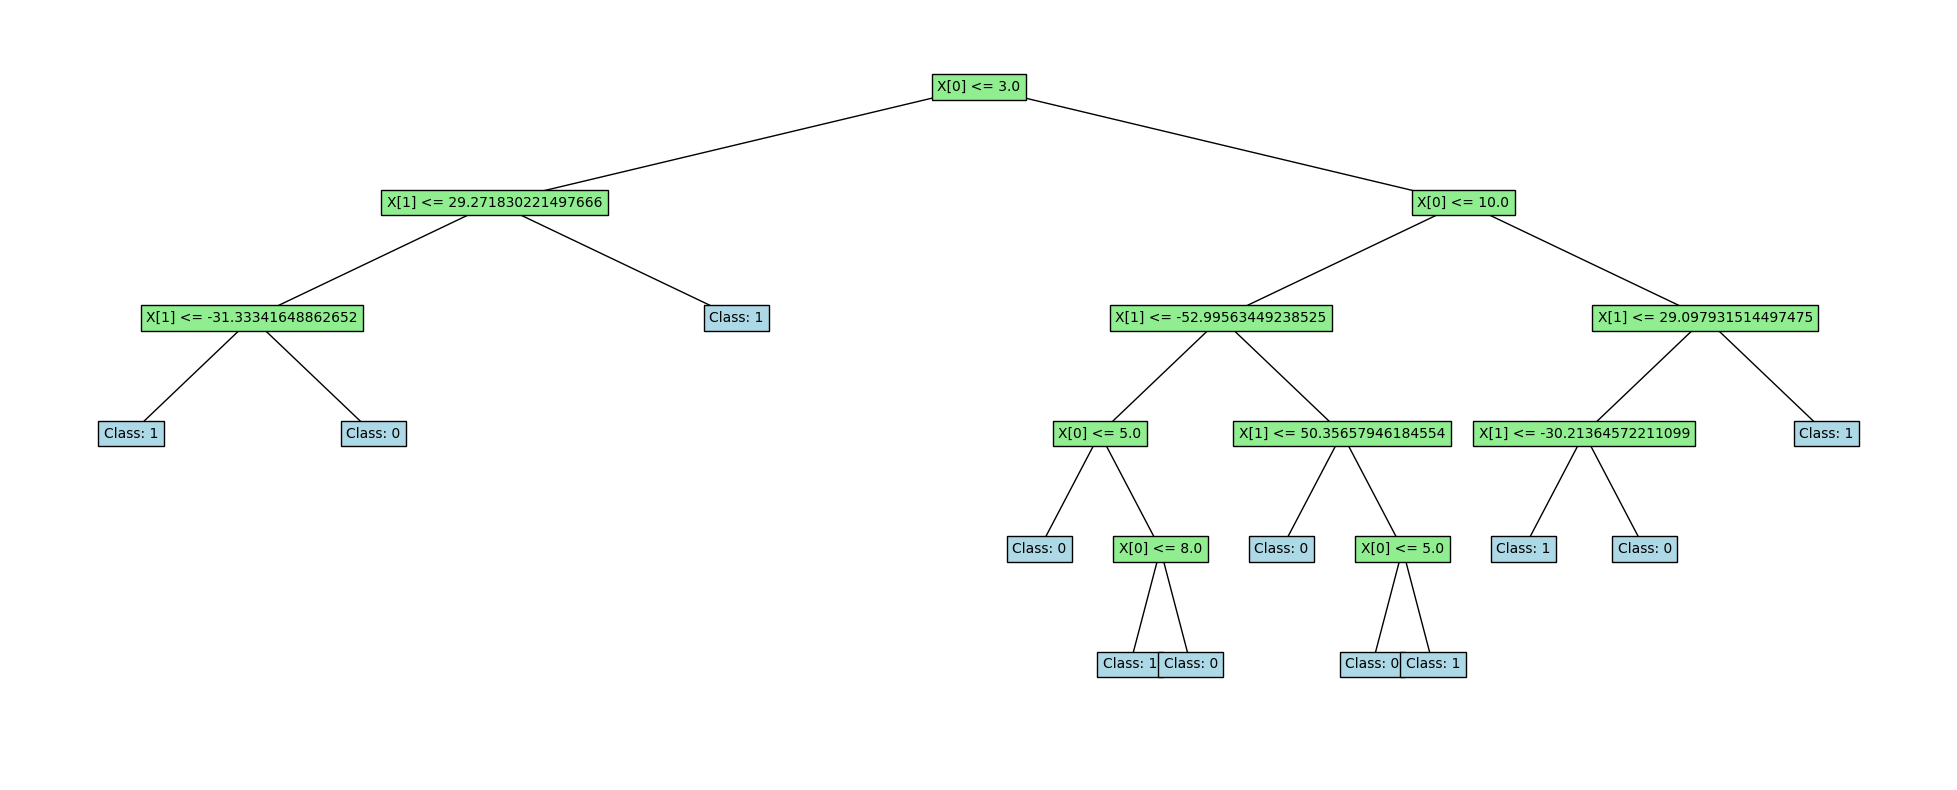

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def get_tree_depth(tree):
    if "label" in tree:
        return 0
    else:
        return 1 + max(get_tree_depth(tree["left"]), get_tree_depth(tree["right"]))

def plot_tree(tree, depth=0, ax=None, pos=(0, 0), layer_spacing=8, depth_spacing=1.5, tree_depth=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(25, 10))
    
    if "label" in tree:
        ax.text(pos[0], pos[1], f'Class: {tree["label"]}', ha='center', va='center',
                bbox=dict(facecolor='lightblue', edgecolor='black'))
    else:
        feature, threshold = tree["feature"], tree["threshold"]
        text = f"X[{feature}] <= {threshold}"
        ax.text(pos[0], pos[1], text, ha='center', va='center',
                bbox=dict(facecolor='lightgreen', edgecolor='black'))

        # Left child
        left_pos = (pos[0] - layer_spacing / 2 ** (depth + 1), pos[1] - depth_spacing)
        arrow_left = FancyArrowPatch(posA=pos, posB=left_pos, arrowstyle='-|>', mutation_scale=10,
                                     color='k', lw=1)
        ax.add_patch(arrow_left)
        plot_tree(tree["left"], depth + 1, ax, left_pos, layer_spacing, depth_spacing, tree_depth)

        # Right child
        right_pos = (pos[0] + layer_spacing / 2 ** (depth + 1), pos[1] - depth_spacing)
        arrow_right = FancyArrowPatch(posA=pos, posB=right_pos, arrowstyle='-|>', mutation_scale=10,
                                      color='k', lw=1)
        ax.add_patch(arrow_right)
        plot_tree(tree["right"], depth + 1, ax, right_pos, layer_spacing, depth_spacing, tree_depth)

    if depth == 0:
        ax.set_xlim(-layer_spacing, layer_spacing)
        ax.set_ylim(-depth_spacing * (tree_depth + 1), 1)
        ax.axis('off')
        plt.show()

# Assuming you have a DecisionTree class with a 'tree' attribute
# and 'X' and 'y' are your data and labels.
tree = DecisionTree(max_depth=5, criterion="gini")
tree.fit(X, y)

# Calculate the maximum depth of the tree
tree_depth = get_tree_depth(tree.tree)
plot_tree(tree.tree, layer_spacing=8, depth_spacing=1.5, tree_depth=tree_depth)


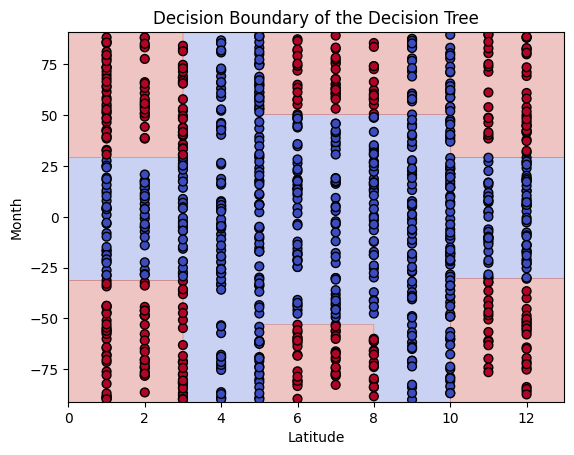

In [10]:
def plot_decision_boundaries(tree, X, y):
    # Define bounds of the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a grid of points with a small step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Use the classifier to predict the class at each grid point
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot the contours
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="coolwarm", edgecolor="k")
    plt.xlabel("Latitude")
    plt.ylabel("Month")
    plt.title("Decision Boundary of the Decision Tree")
    plt.show()

plot_decision_boundaries(tree, X, y)
